In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [2]:
# Step 1: Import Libraries & Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import joblib
from category_encoders import TargetEncoder
import warnings
from sklearn.model_selection import train_test_split, KFold
from category_encoders import CatBoostEncoder
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

df = pd.read_excel('/content/Churn_Prediction.xlsx', sheet_name=0)
df.head(10)

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,Internet_Service,Internet_Type,Online_Security,Online_Backup,Device_Protection_Plan,Premium_Support,Streaming_TV,Streaming_Movies,Streaming_Music,Unlimited_Data,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,11098-MAD,Female,30,Yes,Madhya Pradesh,0,31,Deal 1,Yes,No,Yes,Fiber Optic,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Two Year,No,Bank Withdrawal,951,66834,0,0,63172,731512,Stayed,Others,Others
1,11114-PUN,Male,51,No,Punjab,5,9,Deal 5,Yes,No,Yes,DSL,No,No,Yes,No,No,No,No,No,Month-to-Month,Yes,Bank Withdrawal,4915,16905,0,10,12237,30142,Churned,Competitor,Competitor had better devices
2,11167-WES,Female,43,Yes,West Bengal,3,28,Deal 1,Yes,Yes,Yes,Fiber Optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Two Year,Yes,Bank Withdrawal,11605,82975,4257,110,187298,1023791,Stayed,Others,Others
3,11179-MAH,Male,35,No,Maharashtra,10,12,NaN,Yes,No,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card,844,59693,0,0,21939,618869,Stayed,Others,Others
4,11180-TAM,Male,75,Yes,Tamil Nadu,12,27,Deal 2,Yes,No,Yes,DSL,Yes,No,No,Yes,Yes,Yes,No,No,Two Year,Yes,Credit Card,726,408435,0,140,33208,455643,Stayed,Others,Others
5,11241-MAD,Female,41,Yes,Madhya Pradesh,4,11,NaN,Yes,No,Yes,Fiber Optic,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,1051,36348,0,0,9588,373068,Stayed,Others,Others
6,11244-JAM,Female,20,No,Jammu & Kashmir,3,9,NaN,Yes,Yes,Yes,Cable,Yes,No,No,No,Yes,Yes,Yes,No,One Year,No,Bank Withdrawal,76,158875,73,70,3058,195725,Stayed,Others,Others
7,11251-UTT,Female,51,No,Uttarakhand,1,19,NaN,Yes,Yes,No,NaN,No,No,No,No,No,No,No,No,One Year,No,Bank Withdrawal,252,24515,0,0,2057,26572,Stayed,Others,Others
8,11262-HAR,Female,73,Yes,Haryana,5,32,NaN,Yes,Yes,Yes,Fiber Optic,No,No,No,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,951,951,0,0,489,9999,Churned,Price,Price too high
9,11263-HAR,Female,41,No,Haryana,13,31,Deal 2,Yes,Yes,Yes,Fiber Optic,Yes,No,No,No,Yes,Yes,Yes,Yes,One Year,Yes,Credit Card,9965,63112,0,0,9009,640129,Stayed,Others,Others


In [3]:
#Checking for data imbalance
df['Customer_Status'].value_counts()

,count
Customer_Status,
Stayed,4275
Churned,1732


In [4]:
# Step 2: Preprocessing and Encoding Data

#Drop unnecessary columns
data = df.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason', 'Value_Deal'], axis=1)

#Handle missing values
data['Internet_Type'] = data['Internet_Type'].fillna('None')

#Binary cloumns encoding
binary_cols = ['Gender', 'Married', 'Phone_Service', 'Multiple_Lines',
               'Internet_Service', 'Online_Security', 'Online_Backup',
               'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV',
               'Streaming_Movies', 'Streaming_Music', 'Unlimited_Data',
               'Paperless_Billing']

data[binary_cols] = data[binary_cols].replace({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1}).astype(int)

#Encode target variable
data['Customer_Status'] = data['Customer_Status'].map({'Churned': 1, 'Stayed': 0})

#Define features and target
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']

#Split data before encoding using 80/20 method
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#CatBoost Encoding for 'State'
catboost_cols = ['State']
cb_encoder = CatBoostEncoder(cols=catboost_cols, handle_unknown='value', handle_missing='value', sigma=0.1)
X_train[catboost_cols] = cb_encoder.fit_transform(X_train[catboost_cols], y_train)
X_test[catboost_cols] = cb_encoder.transform(X_test[catboost_cols])

#One-Hot Encoding for 'Internet_Type' and 'Payment_Method'
ohe_cols = ['Internet_Type', 'Payment_Method']
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform data on X_train
ohe_train = pd.DataFrame(
    ohe.fit_transform(X_train[ohe_cols]),
    columns=ohe.get_feature_names_out(ohe_cols),
    index=X_train.index
)

# Transform on test
ohe_test = pd.DataFrame(
    ohe.transform(X_test[ohe_cols]),
    columns=ohe.get_feature_names_out(ohe_cols),
    index=X_test.index
)

# 7.3 Ordinal Encoding for 'Contract'
contract_mapping = {'Two Year': 0, 'One Year': 1, 'Month-to-Month': 2}
X_train['Contract'] = X_train['Contract'].map(contract_mapping)
X_test['Contract'] = X_test['Contract'].map(contract_mapping)

# assign output to the dataset
X_train = X_train.drop(columns=ohe_cols).join(ohe_train)
X_test = X_test.drop(columns=ohe_cols).join(ohe_test)

In [5]:
# Step 3: Train Random Forest Mode

# Applying SMOTE to solve the imbalance of data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Train model with optimal hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=250,
    max_depth=17,
    max_features="sqrt",
    min_samples_leaf=2,
    class_weight='balanced',
    bootstrap=True,
    random_state=42
)
rf_model.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced', max_depth=17,
                       min_samples_leaf=2, n_estimators=250, random_state=42)

In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Confusion Matrix:
[[736 111]
 [ 98 257]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       847
           1       0.70      0.72      0.71       355

    accuracy                           0.83      1202
   macro avg       0.79      0.80      0.79      1202
weighted avg       0.83      0.83      0.83      1202



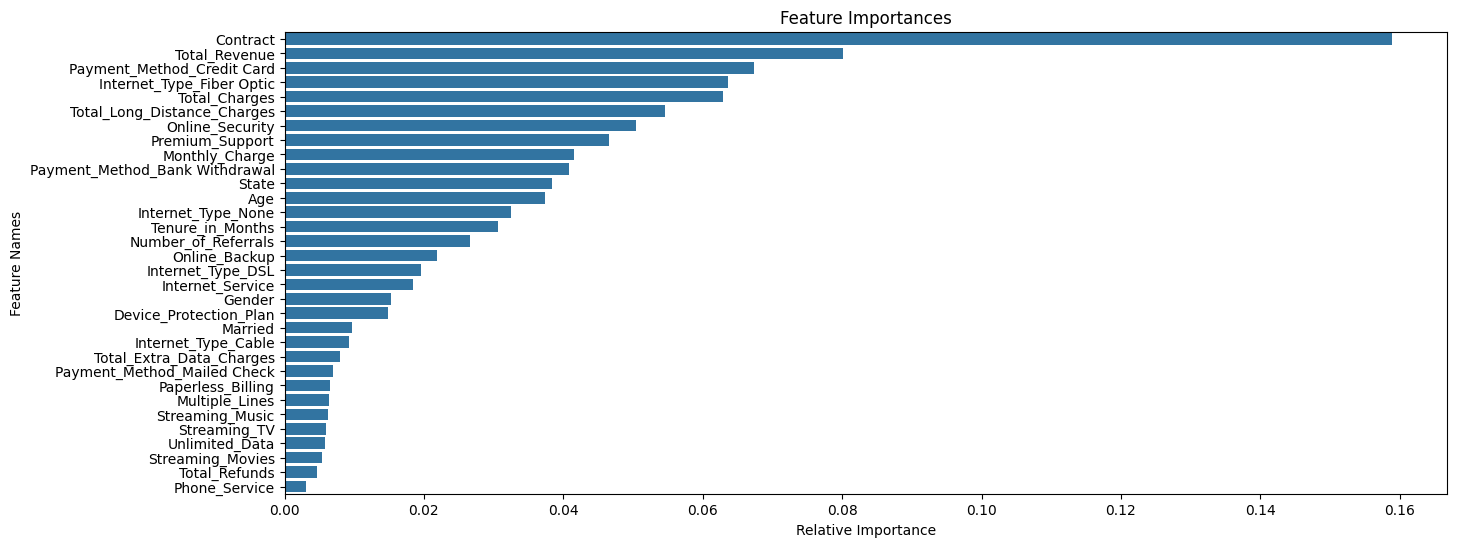

In [6]:
# Step 4: Evaluate Model

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Selection using Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(15, 6))
# Use X_train.columns instead of X.columns
sns.barplot(x=importances[indices], y=X_train.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.show()


In [ ]:
## PREDICT NEW DATA

In [7]:
new_data = pd.read_excel('/content/Churn_Prediction.xlsx', sheet_name=1)
new_data.head(10)


,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,Internet_Service,Internet_Type,Online_Security,Online_Backup,Device_Protection_Plan,Premium_Support,Streaming_TV,Streaming_Movies,Streaming_Music,Unlimited_Data,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,11751-TAM,Female,18,No,Tamil Nadu,5,7,Deal 5,No,No,Yes,DSL,No,No,No,No,No,No,No,Yes,Month-to-Month,No,Mailed Check,243,3845,0,0,0,3845,Joined,Others,Others
1,12056-WES,Male,27,No,West Bengal,2,20,NaN,Yes,No,Yes,Fiber Optic,No,Yes,Yes,No,No,Yes,Yes,Yes,Month-to-Month,No,Bank Withdrawal,904,26845,0,0,9444,36289,Joined,Others,Others
2,12136-RAJ,Female,25,Yes,Rajasthan,2,35,NaN,Yes,No,No,NaN,No,No,No,No,No,No,No,No,Month-to-Month,No,Bank Withdrawal,199,199,0,0,1183,3173,Joined,Others,Others
3,12257-ASS,Female,39,No,Assam,9,1,NaN,Yes,No,No,NaN,No,No,No,No,No,No,No,No,Month-to-Month,Yes,Credit Card,1955,1955,0,0,102,2975,Joined,Others,Others
4,12340-DEL,Female,51,Yes,Delhi,0,10,NaN,Yes,No,Yes,Cable,No,No,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Credit Card,628,628,0,0,4219,10499,Joined,Others,Others
5,12469-AND,Male,24,Yes,Andhra Pradesh,11,4,NaN,Yes,No,Yes,DSL,No,No,No,No,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,553,553,0,0,3669,9199,Joined,Others,Others
6,12490-TEL,Female,52,No,Telangana,9,6,NaN,Yes,No,Yes,Fiber Optic,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Mailed Check,7475,2381,3884,0,375,23676,Joined,Others,Others
7,13058-MAD,Female,58,No,Madhya Pradesh,13,22,NaN,Yes,No,Yes,DSL,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Mailed Check,461,13015,0,0,798,13813,Joined,Others,Others
8,13123-BIH,Female,46,No,Bihar,13,18,Deal 5,Yes,No,Yes,Fiber Optic,Yes,Yes,No,No,Yes,Yes,Yes,No,Month-to-Month,No,Bank Withdrawal,1002,1985,0,10,4512,25362,Joined,Others,Others
9,13666-UTT,Male,57,Yes,Uttarakhand,15,16,NaN,Yes,No,Yes,Fiber Optic,No,Yes,No,No,Yes,Yes,Yes,Yes,Month-to-Month,No,Bank Withdrawal,954,29315,0,0,5103,34418,Joined,Others,Others


In [8]:
# Retain the original DataFrame to preserve unencoded columns
original_data = new_data.copy()

# Retain the Customer_ID column
customer_ids = new_data['Customer_ID']

# Drop columns that won't be used for prediction in the encoded DataFrame
new_data = new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason','Value_Deal'], axis=1)
new_data['Internet_Type'] = new_data['Internet_Type'].fillna('None')

In [9]:
# Apply binary encoding to the new data
new_data[binary_cols] = new_data[binary_cols].replace({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1}).astype(int)

#Proceed with the other encoding steps:
new_data['State'] = cb_encoder.transform(new_data[['State']])
ohe_new = pd.DataFrame(
    ohe.transform(new_data[['Internet_Type', 'Payment_Method']]),
    columns=ohe.get_feature_names_out(['Internet_Type', 'Payment_Method']),
    index=new_data.index
)

# 1.4 Ordinal Mapping cho 'Contract' (giống Step 7.3 trong code train)
contract_mapping = {'Two Year': 0, 'One Year': 1, 'Month-to-Month': 2}
new_data['Contract'] = new_data['Contract'].map(contract_mapping).fillna(-1)  # Xử lý giá trị lạ bằng -1
new_data = new_data.drop(columns=['Internet_Type', 'Payment_Method']).join(ohe_new)

In [10]:
# Make predictions
new_predictions = rf_model.predict(new_data)

# Add predictions to the original DataFrame
original_data['Customer_Status_Predicted'] = new_predictions

# Filter the DataFrame to include only records predicted as "Churned"
original_data = original_data[original_data['Customer_Status_Predicted'] == 1]
original_data['Internet_Type'] = original_data['Internet_Type'].replace({'None': np.nan})

# Save the results
original_data.to_csv(r"Predictions1.csv", index=False)


In [ ]:
original_data.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,Internet_Service,Internet_Type,Online_Security,Online_Backup,Device_Protection_Plan,Premium_Support,Streaming_TV,Streaming_Movies,Streaming_Music,Unlimited_Data,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason,Customer_Status_Predicted
0,11751-TAM,Female,18,No,Tamil Nadu,5,7,Deal 5,No,No,Yes,DSL,No,No,No,No,No,No,No,Yes,Month-to-Month,No,Mailed Check,243,3845,0,0,0,3845,Joined,Others,Others,1
1,12056-WES,Male,27,No,West Bengal,2,20,NaN,Yes,No,Yes,Fiber Optic,No,Yes,Yes,No,No,Yes,Yes,Yes,Month-to-Month,No,Bank Withdrawal,904,26845,0,0,9444,36289,Joined,Others,Others,1
2,12136-RAJ,Female,25,Yes,Rajasthan,2,35,NaN,Yes,No,No,NaN,No,No,No,No,No,No,No,No,Month-to-Month,No,Bank Withdrawal,199,199,0,0,1183,3173,Joined,Others,Others,1
4,12340-DEL,Female,51,Yes,Delhi,0,10,NaN,Yes,No,Yes,Cable,No,No,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Credit Card,628,628,0,0,4219,10499,Joined,Others,Others,1
5,12469-AND,Male,24,Yes,Andhra Pradesh,11,4,NaN,Yes,No,Yes,DSL,No,No,No,No,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,553,553,0,0,3669,9199,Joined,Others,Others,1
